In [3]:
# Import libraries and reload data due to kernel reset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



# Load the dataset
df = pd.read_csv("train.csv")

# Step 1: Identify duplicated texts with conflicting emotions
duplicates = df[df.duplicated(subset='text', keep=False)].copy()
grouped = duplicates.groupby('text')['emotion'].nunique()
conflicting_texts = grouped[grouped > 1].index.tolist()
conflicting_df = df[df['text'].isin(conflicting_texts)]

In [4]:
conflicting_df

,text,emotion
165,im feeling really weird,worry
256,i feel a bit strange saying it,worry
326,i think about having to see shigeru again the ...,hate
1090,i bit my lip as he slightly whispered this wil...,worry
2096,i feel a remembrance of the strange by justin ...,worry
2364,i think i brag and it feels strange because i ...,worry
2535,i think about having to see shigeru again the ...,worry
2611,i feel so weird not saying goodnight to mike,worry
3962,i dont know why but i had started to feel the ...,worry
4123,i know i feel agitated like the volcanos sudde...,hate


In [5]:
# Step 2: Compute TF-IDF vectors for all texts
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['text'])

# Step 3: Calculate centroids per emotion
emotion_centroids = {}
for emotion in df['emotion'].unique():
    indices = df[df['emotion'] == emotion].index
    emotion_vectors = X_tfidf[indices]
    centroid = emotion_vectors.mean(axis=0)
    emotion_centroids[emotion] = np.asarray(centroid)

# Step 4: Resolve conflicting labels using cosine similarity
resolved_entries = []
for text in conflicting_texts:
    text_vector = tfidf.transform([text])
    similarities = {
        emotion: cosine_similarity(text_vector, centroid)[0][0]
        for emotion, centroid in emotion_centroids.items()
    }
    best_emotion = max(similarities, key=similarities.get)
    resolved_entries.append({
        "text": text,
        "resolved_emotion": best_emotion,
        "similarities": similarities
    })

resolved_df = pd.DataFrame(resolved_entries)

resolved_df

,text,resolved_emotion,similarities
0,i bit my lip as he slightly whispered this wil...,surprise,"{'neutral': 0.09252970912901023, 'happiness': ..."
1,i dont know why but i had started to feel the ...,worry,"{'neutral': 0.16104253961951195, 'happiness': ..."
2,i feel a bit strange saying it,surprise,"{'neutral': 0.06936988590367928, 'happiness': ..."
3,i feel a remembrance of the strange by justin ...,surprise,"{'neutral': 0.0993396173265958, 'happiness': 0..."
4,i feel like he admired her more than me,happiness,"{'neutral': 0.06094244096255345, 'happiness': ..."
5,i feel so weird not saying goodnight to mike,surprise,"{'neutral': 0.06154365109037152, 'happiness': ..."
6,i feel strongly about supporting my school and...,happiness,"{'neutral': 0.05355895626179411, 'happiness': ..."
7,i know i feel agitated like the volcanos sudde...,hate,"{'neutral': 0.0618310060721428, 'happiness': 0..."
8,i really do feel so blessed and thankful for a...,fun,"{'neutral': 0.15882172069036343, 'happiness': ..."
9,i think about having to see shigeru again the ...,worry,"{'neutral': 0.24623267946309413, 'happiness': ..."


In [6]:
# Step 5: Create similarity_view DataFrame
similarity_view = pd.DataFrame({
    'text': resolved_df['text'],
    'resolved_emotion': resolved_df['resolved_emotion'],
    'most_similar_emotion': resolved_df['similarities'].apply(lambda d: max(d, key=d.get)),
    'max_similarity': resolved_df['similarities'].apply(lambda d: max(d.values()))
})

similarity_view

,text,resolved_emotion,most_similar_emotion,max_similarity
0,i bit my lip as he slightly whispered this wil...,surprise,surprise,0.175839
1,i dont know why but i had started to feel the ...,worry,worry,0.204253
2,i feel a bit strange saying it,surprise,surprise,0.219865
3,i feel a remembrance of the strange by justin ...,surprise,surprise,0.134289
4,i feel like he admired her more than me,happiness,happiness,0.202773
5,i feel so weird not saying goodnight to mike,surprise,surprise,0.149222
6,i feel strongly about supporting my school and...,happiness,happiness,0.169135
7,i know i feel agitated like the volcanos sudde...,hate,hate,0.145780
8,i really do feel so blessed and thankful for a...,fun,fun,0.285347
9,i think about having to see shigeru again the ...,worry,worry,0.249371


In [7]:
# Step 6: Clean and update the original dataset
df_cleaned = df[~df['text'].isin(similarity_view['text'])].copy()
resolved_rows = similarity_view[['text', 'resolved_emotion']].rename(columns={'resolved_emotion': 'emotion'})
df_updated = pd.concat([df_cleaned, resolved_rows], ignore_index=True) 

df_updated

,text,emotion
0,Yeah for coupons! Found this place randomly ...,neutral
1,i still love to feel a gentle breeze and hear ...,happiness
2,"Normal, fama devido ao programa de tv. A sobre...",neutral
3,im feeling a little less jaded,sadness
4,i have never shaken the feeling of ferocious p...,hate
...,...,...
7982,i really do feel so blessed and thankful for a...,fun
7983,i think about having to see shigeru again the ...,worry
7984,i think i brag and it feels strange because i ...,surprise
7985,i write this i m sipping on a martini which is...,happiness


In [8]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import contractions

# Prepare stopwords and lemmatizer
stop_words = set(stopwords.words("english")) - {"not", "no"}  # Keep "not"/"no"
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocessing function
def preprocess_text(text, lemmatize=False, stem=False):
    # Expand contractions
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r"@\w+|#\w+", '', text)                # Remove mentions and hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()             # Normalize whitespace

    # Extract words only (ignore numbers, keep words with apostrophes like don't -> do not)
    tokens = re.findall(r"[a-zA-Z']+", text)

    # Remove stopwords and apply lemmatization or stemming
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    elif stem:
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    else:
        tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

# Apply the preprocessing variants to df_updated
df_updated['text_clean'] = df_updated['text'].apply(lambda x: preprocess_text(x, lemmatize=False, stem=False))
df_updated['text_lemmatized'] = df_updated['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
df_updated['text_stemmed'] = df_updated['text'].apply(lambda x: preprocess_text(x, stem=True))


In [9]:
df_updated['text_clean']

0       yeah coupons found place randomly really like ...
1       still love feel gentle breeze hear peal soft w...
2       normal fama devido ao programa de tv sobremesa...
3                               feeling little less jaded
4       never shaken feeling ferocious protectiveness ...
                              ...                        
7982                         really feel blessed thankful
7983    think see shigeru sicker feel agitated forgot ...
7984    think brag feels strange still see little fatt...
7985      write sipping martini probably feeling generous
7986                                 feeling really weird
Name: text_clean, Length: 7987, dtype: object

In [10]:
df_updated['text_lemmatized']

0       yeah coupons find place randomly really like l...
1       still love feel gentle breeze hear peal soft w...
2       normal fama devido ao programa de tv sobremesa...
3                                   feel little less jade
4       never shake feel ferocious protectiveness firs...
                              ...                        
7982                           really feel bless thankful
7983    think see shigeru sicker feel agitate forget w...
7984    think brag feel strange still see little fatti...
7985             write sip martini probably feel generous
7986                                    feel really weird
Name: text_lemmatized, Length: 7987, dtype: object

In [11]:
df_updated['text_stemmed']

0       yeah coupon found place randomli realli like l...
1       still love feel gentl breez hear peal soft win...
2       normal fama devido ao programa de tv sobremesa...
3                                    feel littl less jade
4       never shaken feel feroci protect first becam m...
                              ...                        
7982                              realli feel bless thank
7983    think see shigeru sicker feel agit forgot wate...
7984    think brag feel strang still see littl fatti p...
7985                 write sip martini probabl feel gener
7986                                    feel realli weird
Name: text_stemmed, Length: 7987, dtype: object

In [15]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import contractions

# Prepare stopwords and lemmatizer
stop_words = set(stopwords.words("english")) - {"not", "no"}  # Keep "not"/"no"
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocessing function
def preprocess_text(text, lemmatize=False, stem=False):
    # Expand contractions
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\b(?:http|https|www|href)\b\S*', '', text)  # Remove links
    text = re.sub(r"@\w+|#\w+", '', text)                # Remove mentions and hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()             # Normalize whitespace

    # Extract words only (ignore numbers, keep words with apostrophes like don't -> do not)
    tokens = re.findall(r"[a-zA-Z']+", text)

    # Remove stopwords and apply lemmatization or stemming
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    elif stem:
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    else:
        tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

# Apply the preprocessing variants to df_updated
df_updated['text_clean'] = df_updated['text'].apply(lambda x: preprocess_text(x, lemmatize=False, stem=False))
df_updated['text_lemmatized'] = df_updated['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
df_updated['text_stemmed'] = df_updated['text'].apply(lambda x: preprocess_text(x, stem=True))



In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Use lemmatized or clean text
corpus = df_updated['text_lemmatized']  # or 'text_clean'

corpus


0       yeah coupons find place randomly really like l...
1       still love feel gentle breeze hear peal soft w...
2       normal fama devido ao programa de tv sobremesa...
3                                   feel little less jade
4       never shake feel ferocious protectiveness firs...
                              ...                        
7982                           really feel bless thankful
7983    think see shigeru sicker feel agitate forget w...
7984    think brag feel strange still see little fatti...
7985             write sip martini probably feel generous
7986                                    feel really weird
Name: text_lemmatized, Length: 7987, dtype: object

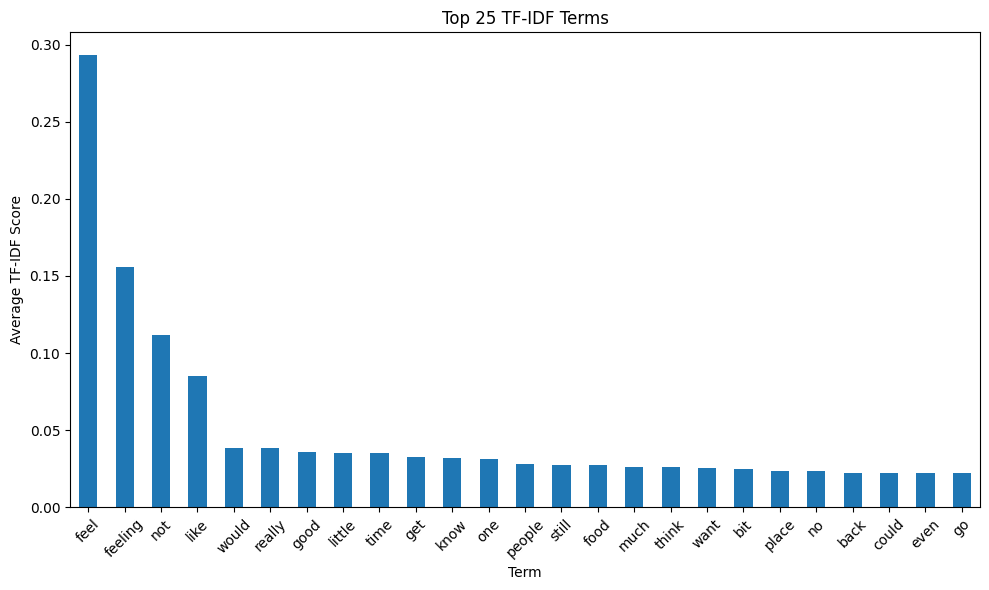

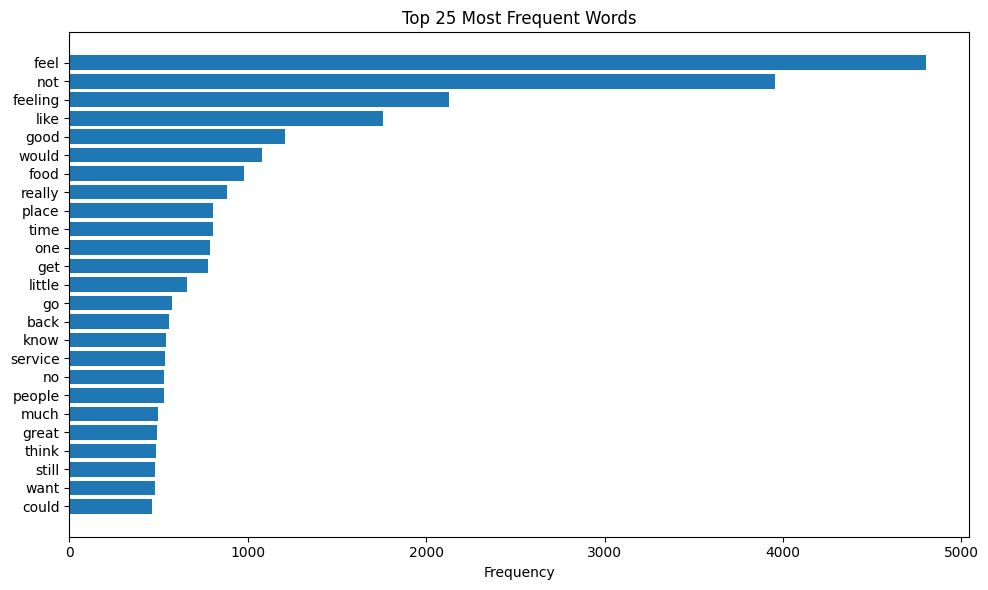

In [20]:
def plot_top_terms(corpus, top_n=20):
    """
    Plot top terms by TF-IDF score and raw frequency.

    Parameters:
    corpus: pd.Series or list of str — the cleaned text data
    top_n: int — number of terms to plot
    """

    # --- TF-IDF ---
    tfidf_vectorizer = TfidfVectorizer(max_features=top_n * 2)  # Fetch more to filter better
    X_tfidf = tfidf_vectorizer.fit_transform(corpus)
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    mean_tfidf = tfidf_df.mean().sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    mean_tfidf.plot(kind='bar')
    plt.title(f"Top {top_n} TF-IDF Terms")
    plt.xlabel("Term")
    plt.ylabel("Average TF-IDF Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Raw Frequency ---
    count_vectorizer = CountVectorizer()
    X_count = count_vectorizer.fit_transform(corpus)
    word_counts = X_count.sum(axis=0)
    count_df = pd.DataFrame([(word, word_counts[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()],
                            columns=["word", "count"])
    top_counts = count_df.sort_values(by="count", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_counts['word'][::-1], top_counts['count'][::-1])
    plt.title(f"Top {top_n} Most Frequent Words")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()



# Using your cleaned column
plot_top_terms(df_updated['text_clean'], top_n=25)

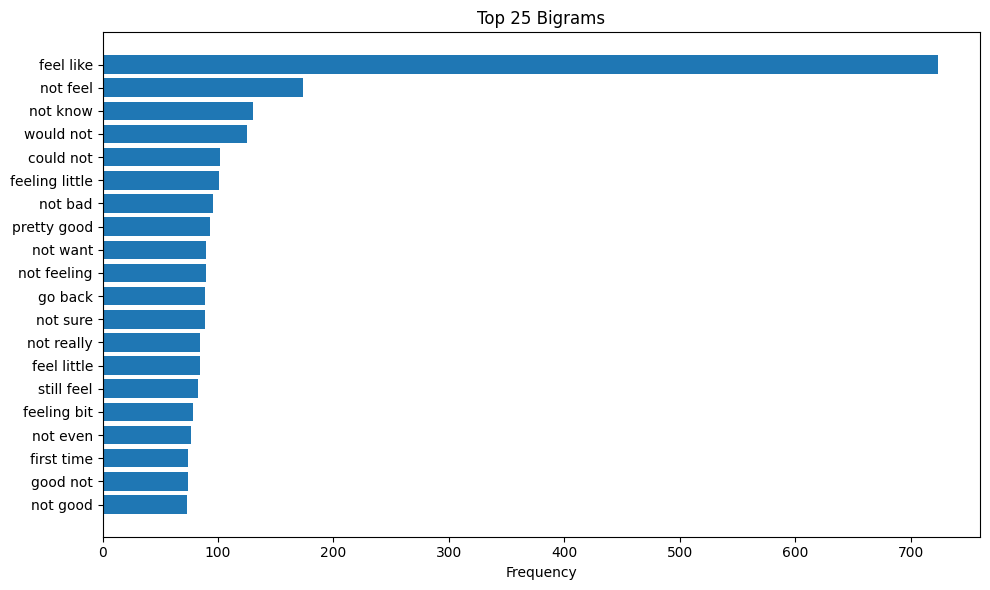

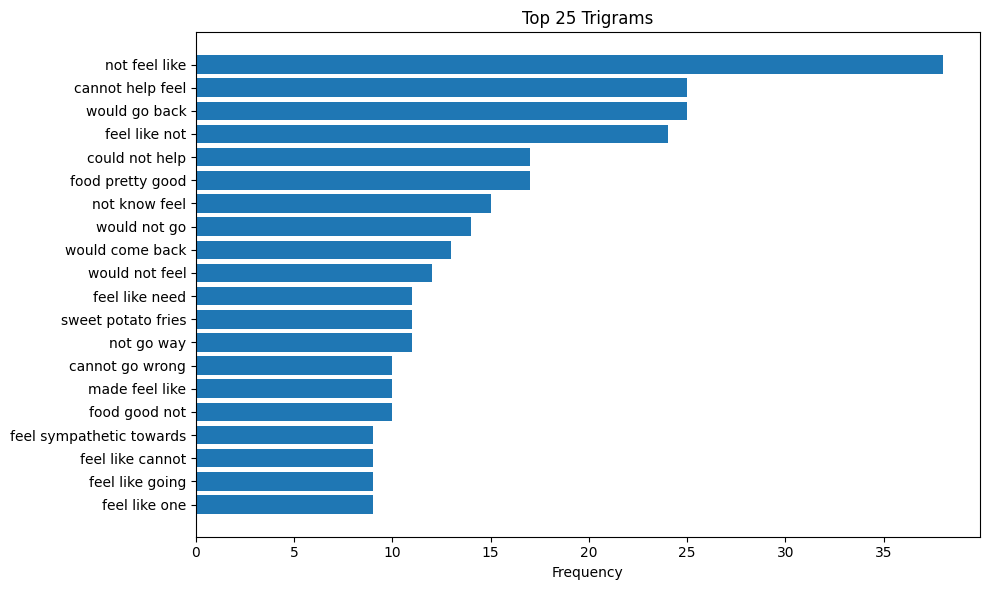

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=50):
    vec = CountVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

# Plotting function
def plot_ngrams(ngrams, title):
    ngrams = ngrams[:20]
    labels, values = zip(*ngrams)
    plt.figure(figsize=(10, 6))
    plt.barh(labels[::-1], values[::-1])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

n = 25;
# Get and plot bigrams
corpus = df_updated['text_clean']
top_bigrams = get_top_ngrams(corpus, ngram_range=(2, 2), top_n=n)
top_trigrams = get_top_ngrams(corpus, ngram_range=(3, 3), top_n=n)
plot_ngrams(top_bigrams, f"Top {n} Bigrams")
plot_ngrams(top_trigrams, f"Top {n} Trigrams")


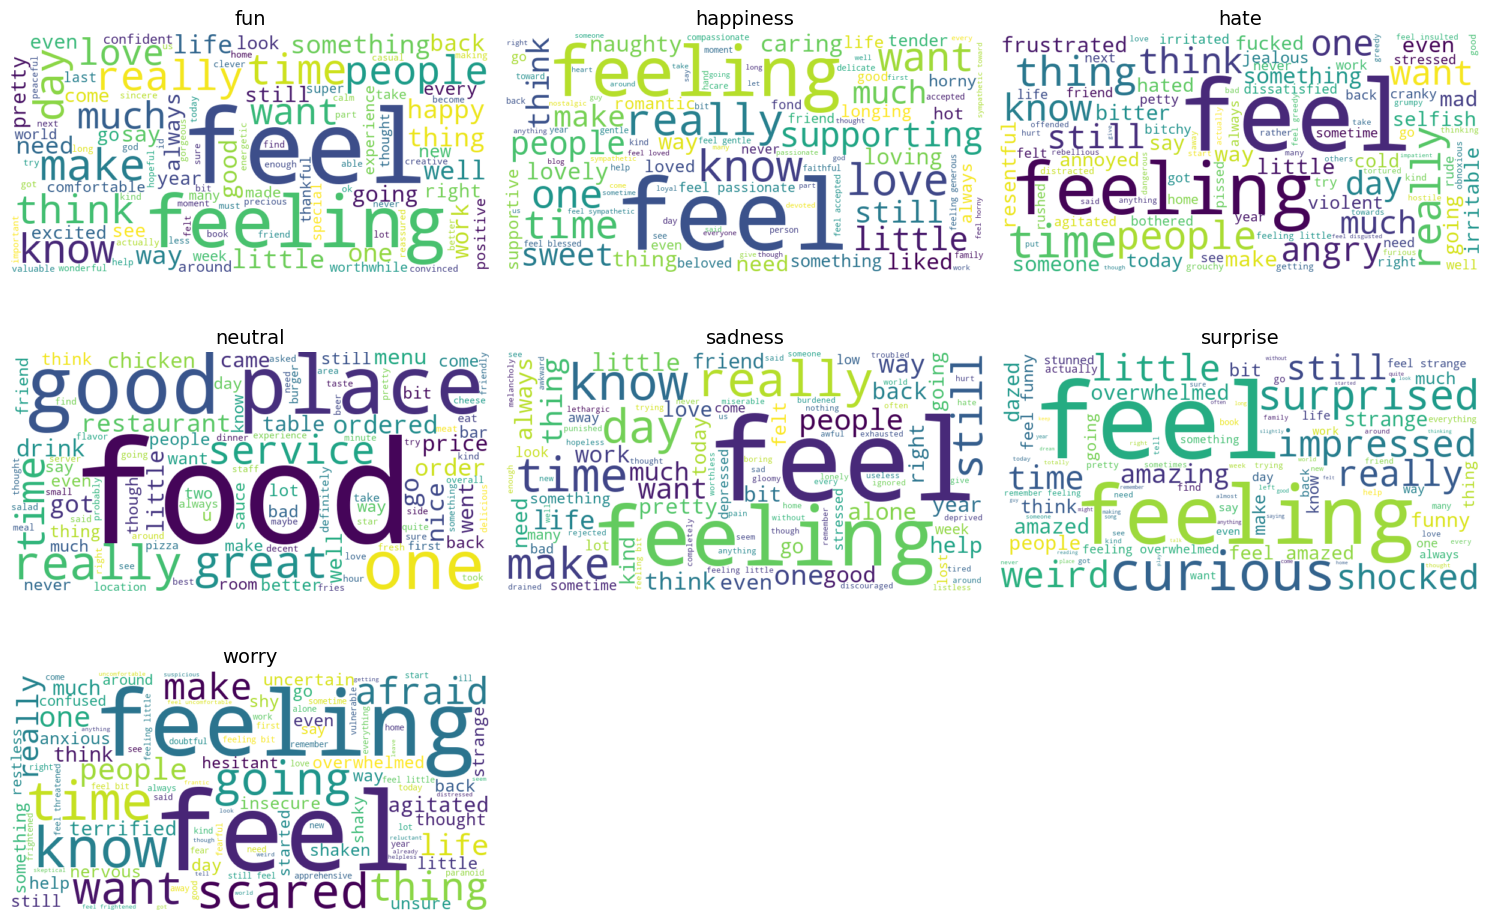

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordclouds_by_emotion(df, text_column='text_clean', label_column='emotion', max_words=100):
    """
    Generate and display word clouds for each emotion in the dataset.

    Parameters:
    df: pandas DataFrame — contains at least text and label columns
    text_column: str — name of the preprocessed text column
    label_column: str — name of the label/emotion column
    max_words: int — number of words to display in each word cloud
    """
    emotions = df[label_column].unique()
    plt.figure(figsize=(15, 10))

    for i, emotion in enumerate(sorted(emotions), 1):
        text = " ".join(df[df[label_column] == emotion][text_column])
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              max_words=max_words, colormap='viridis').generate(text)
        
        plt.subplot(3, 3, i)  # Adjust grid if you have more/less emotions
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(emotion, fontsize=14)

    plt.tight_layout()
    plt.show()


# Assuming 'text_clean' is your cleaned column
generate_wordclouds_by_emotion(df_updated, text_column='text_clean', label_column='emotion', max_words=100)


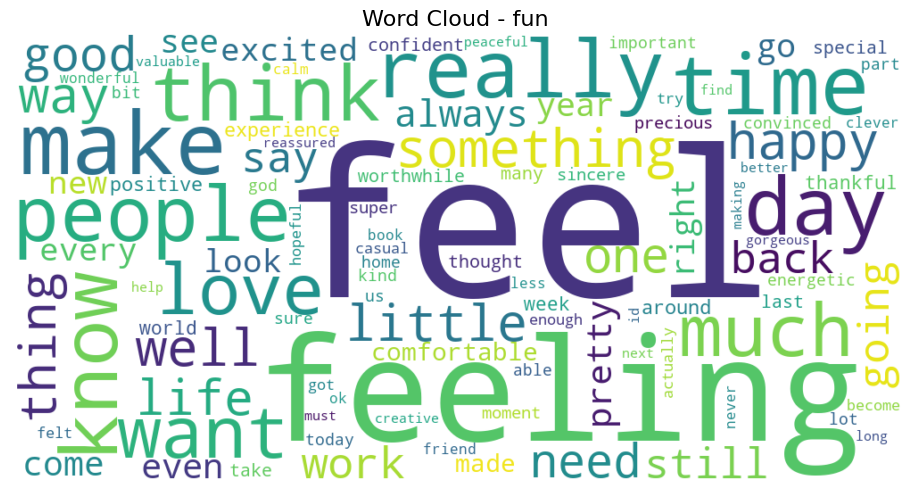

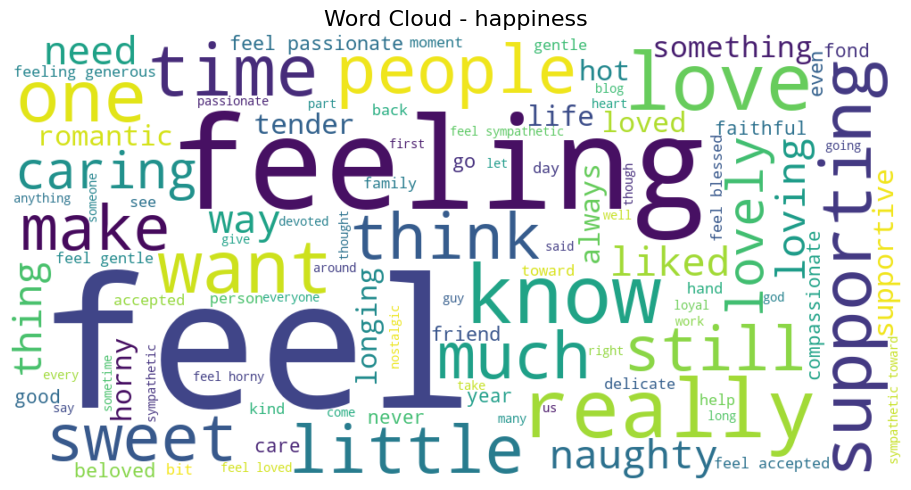

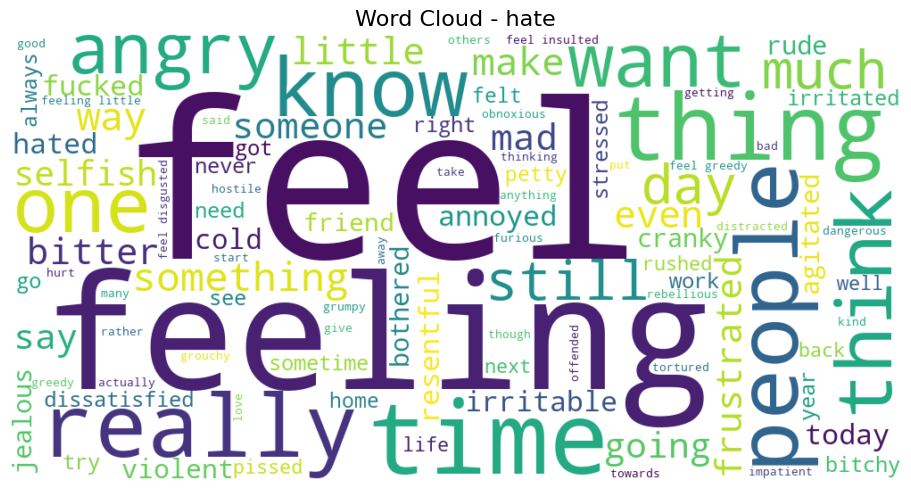

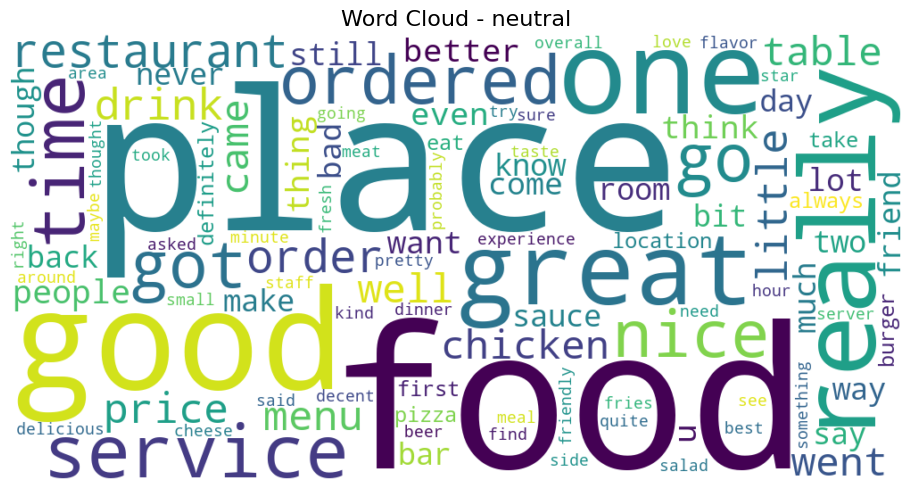

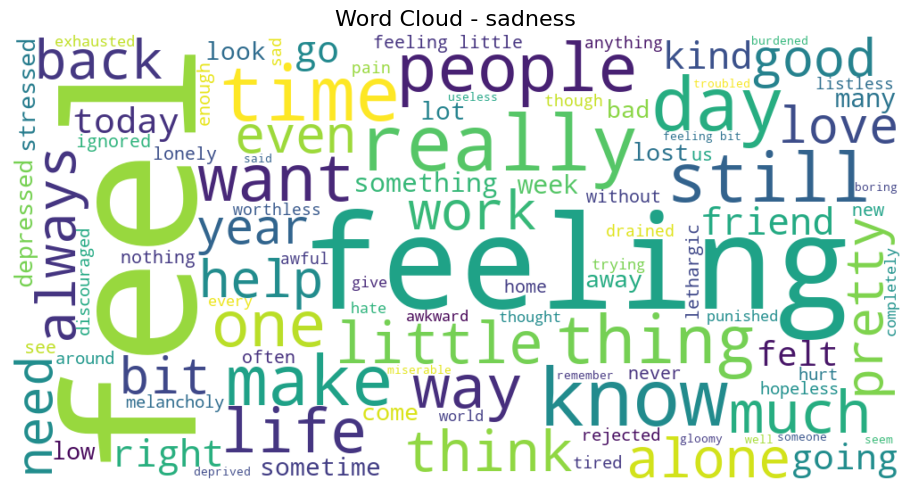

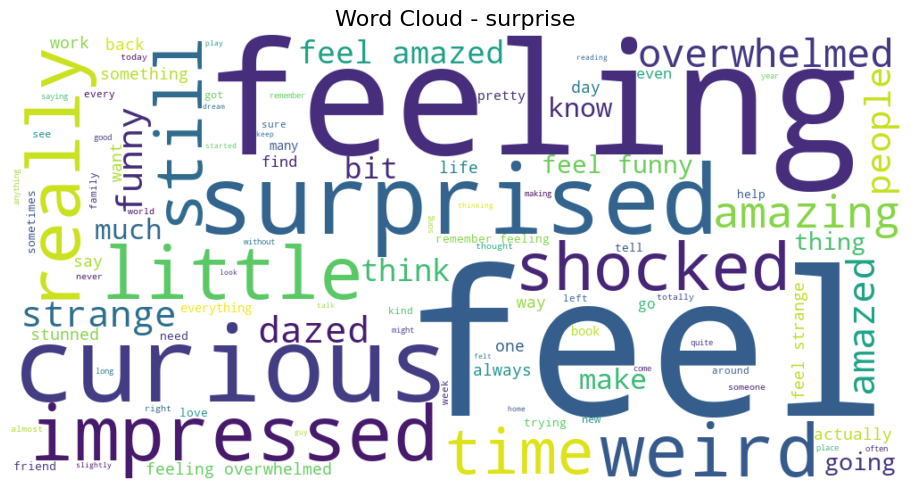

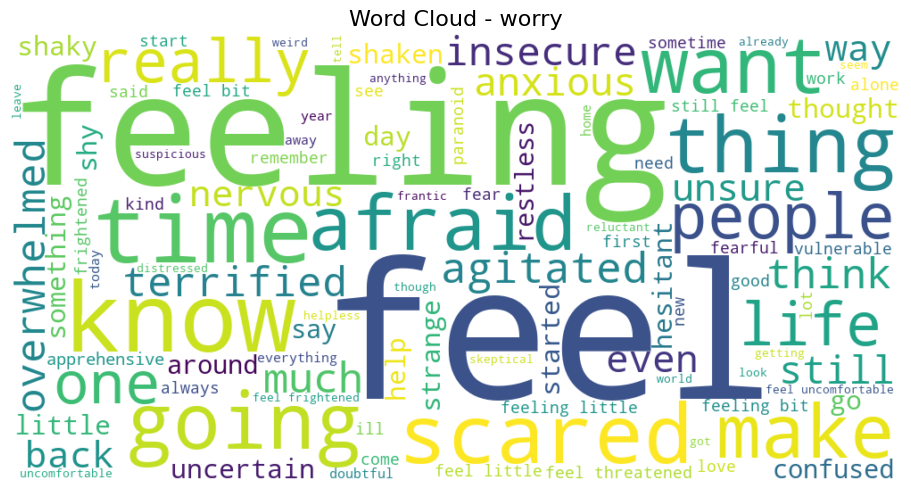

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

def generate_individual_wordclouds_by_emotion(df, text_column='text_clean', label_column='emotion',
                                               max_words=100, save_dir=None):
    """
    Generate individual word cloud plots for each emotion label.

    Parameters:
    df: pandas DataFrame — contains preprocessed text and emotion labels
    text_column: str — name of the column with cleaned text
    label_column: str — name of the emotion label column
    max_words: int — number of words to include in each word cloud
    save_dir: str or None — if provided, saves each plot to the given directory
    """
    emotions = df[label_column].unique()

    for emotion in sorted(emotions):
        text = " ".join(df[df[label_column] == emotion][text_column])
        wordcloud = WordCloud(width=1000, height=500, background_color='white',
                              max_words=max_words, colormap='viridis').generate(text)

        # Show plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud - {emotion}", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Optionally save to file
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            wordcloud.to_file(os.path.join(save_dir, f"wordcloud_{emotion}.png"))


# Just display
generate_individual_wordclouds_by_emotion(df_updated, text_column='text_clean', label_column='emotion')

In [25]:
# Re-import libraries after code execution reset
import pandas as pd
import random
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer


In [26]:
# Setup
stop_words = set(stopwords.words("english")) - {"not", "no"} # Important for sentiment analysis
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Load the dataset again
file_path = "train.csv"
df = pd.read_csv(file_path)

# Preprocessing function
def preprocess_text(text, lemmatize=False, stem=False):
    # Expand contractions
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\b(?:http|https|www|href)\b\S*', '', text)  # Remove links
    text = re.sub(r"@\w+|#\w+", '', text)                # Remove mentions and hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()             # Normalize whitespace

    # Extract words only (ignore numbers, keep words with apostrophes like don't -> do not)
    tokens = re.findall(r"[a-zA-Z']+", text)

    # Remove stopwords and apply lemmatization or stemming
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    elif stem:
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    else:
        tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

# Apply the preprocessing variants to df_updated
df_updated['text_clean'] = df_updated['text'].apply(lambda x: preprocess_text(x, lemmatize=False, stem=False))
df_updated['text_lemmatized'] = df_updated['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
df_updated['text_stemmed'] = df_updated['text'].apply(lambda x: preprocess_text(x, stem=True))



# # Apply preprocessing
# df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x))
# df['text_lemmatized'] = df['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
# df['text_stemmed'] = df['text'].apply(lambda x: preprocess_text(x, stem=True))

# Now rerun model evaluation code
import random

static_state = 42
rand_state = random.randrange(1, 1000**3)

text_variants = {
    "clean": df_updated['text_clean'],
    "lemmatized": df_updated['text_lemmatized'],
    "stemmed": df_updated['text_stemmed']
}

vectorizer_settings = dict(max_features=4500, ngram_range=(1, 2))

base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'SVM': LinearSVC(class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=rand_state),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=rand_state)
}

results = []

for variant_name, text_data in text_variants.items():
    X_train, X_test, y_train, y_test = train_test_split(
        text_data, df_updated["emotion"], test_size=0.4, random_state=rand_state, stratify=df_updated["emotion"]
    )

    vectorizer = TfidfVectorizer(**vectorizer_settings)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    for model_name, model in base_models.items():
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Variant': variant_name,
            'Model': model_name,
            'Accuracy': round(accuracy_score(y_test, y_pred), 4),
            'Macro F1': round(report['macro avg']['f1-score'], 4),
            'Weighted F1': round(report['weighted avg']['f1-score'], 4)
        })

    best_k = None
    best_score = 0
    for k in range(3, 31, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_tfidf, y_train)
        score = knn.score(X_test_tfidf, y_test)
        if score > best_score:
            best_k = k
            best_score = score

    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_tfidf, y_train)
    y_pred = knn.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Variant': variant_name,
        'Model': f'kNN - {best_k}',
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Macro F1': round(report['macro avg']['f1-score'], 4),
        'Weighted F1': round(report['weighted avg']['f1-score'], 4)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df




,Variant,Model,Accuracy,Macro F1,Weighted F1
0,clean,Logistic Regression,0.8808,0.8767,0.8800
1,clean,SVM,0.8905,0.8858,0.8896
2,clean,Naive Bayes,0.7834,0.7445,0.7717
3,clean,Decision Tree,0.7931,0.7900,0.7927
4,clean,Random Forest,0.8435,0.8392,0.8426
5,clean,kNN - 29,0.8063,0.7981,0.8032
6,lemmatized,Logistic Regression,0.8757,0.8740,0.8753
7,lemmatized,SVM,0.8804,0.8767,0.8800
8,lemmatized,Naive Bayes,0.7790,0.7462,0.7690
9,lemmatized,Decision Tree,0.7768,0.7768,0.7756


In [27]:
y_pred

array(['hate', 'fun', 'hate', ..., 'happiness', 'hate', 'neutral'],
      shape=(3195,), dtype=object)

In [28]:
import re
from collections import Counter
import nltk
from nltk.corpus import words, stopwords

# Tokenization and preprocessing
def tokenize_text(text):
    # Lowercase and split on non-word characters
    return re.findall(r'\b\w+\b', text.lower())

# Apply tokenization to each row
all_tokens = df['text'].apply(tokenize_text)

# Flatten all tokens into a single list using nested for-loops
flat_tokens = []
for sublist in all_tokens:
    for token in sublist:
        flat_tokens.append(token)

# Count token frequencies
token_counts = Counter()
for token in flat_tokens:
    token_counts[token] += 1

# Get English and stopword sets
english_words = set(words.words())
stop_words = set(stopwords.words('english'))

# Identify non-character words
non_character_words = []
for word in token_counts:
    if not word.isalpha():
        non_character_words.append(word)

# Identify non-English words
non_english_words = []
for word in token_counts:
    if word.isalpha() and word not in english_words and word not in stop_words:
        non_english_words.append(word)

# Construct non-character dictionary
non_char_dict = {}
for word in non_character_words:
    non_char_dict[word] = token_counts[word]

# Construct non-English dictionary
non_english_dict = {}
for word in non_english_words:
    non_english_dict[word] = token_counts[word]


In [29]:
# Top examples of non-character words 
Counter(non_char_dict).most_common(25)



[('3', 248),
 ('5', 230),
 ('2', 178),
 ('4', 154),
 ('10', 100),
 ('1', 91),
 ('15', 77),
 ('30', 65),
 ('50', 63),
 ('7', 61),
 ('20', 60),
 ('6', 56),
 ('8', 51),
 ('9', 40),
 ('99', 37),
 ('12', 35),
 ('00', 28),
 ('45', 24),
 ('25', 24),
 ('11', 23),
 ('100', 23),
 ('40', 17),
 ('14', 15),
 ('95', 14),
 ('24', 13)]

In [30]:
# Least common examples of non-character words 
Counter(non_char_dict).most_common()[:25:-1]

[('40k', 1),
 ('14th', 1),
 ('650', 1),
 ('160', 1),
 ('38', 1),
 ('118', 1),
 ('48', 1),
 ('9p', 1),
 ('8p', 1),
 ('b4', 1),
 ('8am', 1),
 ('3d', 1),
 ('2215', 1),
 ('40th', 1),
 ('ny54', 1),
 ('32nd', 1),
 ('5am', 1),
 ('273', 1),
 ('140', 1),
 ('52', 1),
 ('1980', 1),
 ('101', 1),
 ('48oz', 1),
 ('3x', 1),
 ('31st', 1),
 ('1999', 1),
 ('700', 1),
 ('20mn', 1),
 ('215', 1),
 ('114', 1),
 ('2mins', 1),
 ('1990ties', 1),
 ('2007', 1),
 ('264', 1),
 ('24hrs', 1),
 ('s3', 1),
 ('33', 1),
 ('6ix', 1),
 ('000', 1),
 ('1895', 1),
 ('dvk685xtia', 1),
 ('v6gelkzrfch', 1),
 ('media1', 1),
 ('96', 1),
 ('515', 1),
 ('945', 1),
 ('1130', 1),
 ('545', 1),
 ('d1', 1),
 ('2am', 1),
 ('29', 1),
 ('1950', 1),
 ('109', 1),
 ('30mins', 1),
 ('240', 1),
 ('349', 1),
 ('175', 1),
 ('2011', 1),
 ('7p', 1),
 ('1950s', 1),
 ('76th', 1),
 ('m5t', 1),
 ('298', 1),
 ('1960', 1),
 ('7ish', 1),
 ('k45', 1),
 ('3oz', 1),
 ('5oz', 1),
 ('64', 1),
 ('830', 1),
 ('69', 1),
 ('125', 1),
 ('7356', 1),
 ('494', 1),
 ('

In [31]:
# Top examples of non-English words 
Counter(non_english_dict).most_common(25)

[('im', 975),
 ('things', 335),
 ('ok', 209),
 ('ive', 199),
 ('minutes', 187),
 ('friends', 182),
 ('feelings', 170),
 ('wanted', 167),
 ('feels', 164),
 ('drinks', 156),
 ('asked', 151),
 ('makes', 151),
 ('stars', 146),
 ('fries', 139),
 ('burger', 139),
 ('liked', 139),
 ('loved', 137),
 ('places', 122),
 ('years', 122),
 ('prices', 119),
 ('started', 119),
 ('sushi', 116),
 ('overwhelmed', 115),
 ('okay', 112),
 ('looked', 111)]

In [32]:
# Least common examples of non-character words 
Counter(non_english_dict).most_common()[:25:-1]

[('outta', 1),
 ('bosaale', 1),
 ('kulfi', 1),
 ('chilis', 1),
 ('paratha', 1),
 ('remodeling', 1),
 ('miscalculated', 1),
 ('thusfar', 1),
 ('endings', 1),
 ('krishna', 1),
 ('mangala', 1),
 ('harinama', 1),
 ('calvary', 1),
 ('ties', 1),
 ('wanya', 1),
 ('contrasting', 1),
 ('decore', 1),
 ('nightlife', 1),
 ('bankers', 1),
 ('pilfered', 1),
 ('wallets', 1),
 ('concocted', 1),
 ('vampires', 1),
 ('freshest', 1),
 ('craves', 1),
 ('substitued', 1),
 ('restaurat', 1),
 ('restauranty', 1),
 ('contradictions', 1),
 ('musicmemorabiliaauction', 1),
 ('rpm', 1),
 ('gamers', 1),
 ('luxy', 1),
 ('motors', 1),
 ('miley', 1),
 ('mariah', 1),
 ('cena', 1),
 ('passions', 1),
 ('bsc', 1),
 ('msc', 1),
 ('soondubu', 1),
 ('nicholsons', 1),
 ('iness', 1),
 ('wok', 1),
 ('fiddlesticks', 1),
 ('lanzhou', 1),
 ('andiamos', 1),
 ('deserts', 1),
 ('augratin', 1),
 ('lugers', 1),
 ('pbr', 1),
 ('tilted', 1),
 ('knocks', 1),
 ('disallusioned', 1),
 ('katja', 1),
 ('celles', 1),
 ('tranquille', 1),
 ('arriγ

In [33]:
# Re-import necessary libraries after code execution reset
import pandas as pd
import re
from collections import Counter
import nltk
import contractions

# Load the uploaded CSV file again
file_path = "train.csv"
df = pd.read_csv(file_path)

# Function to expand contractions in a text string
def expand_contractions(text):
    return contractions.fix(text)

# Apply contraction expansion to the 'text' column
df['text_expanded'] = df['text'].apply(expand_contractions)

# Show a few examples of original vs. expanded text
df[['text', 'text_expanded']].tail(25)

,text,text_expanded
7975,i feel satisfaction for only about five minute...,i feel satisfaction for only about five minute...
7976,i am feeling optimistic about it i think he ll...,i am feeling optimistic about it i think he ll...
7977,i want to feel accepted for me,i want to feel accepted for me
7978,i met someone who makes me feel so treasured r...,i met someone who makes me feel so treasured r...
7979,i feel like i have been put on this earth to b...,i feel like i have been put on this earth to b...
7980,i began to feel horny,i began to feel horny
7981,i am constantly focused on the fans behind me ...,i am constantly focused on the fans behind me ...
7982,i feel like i m damaged goods and that he dese...,i feel like i m damaged goods and that he dese...
7983,i have to admit she has opened up about her fe...,i have to admit she has opened up about her fe...
7984,i am hating myself at the moment because i fee...,i am hating myself at the moment because i fee...


In [34]:
from nltk.corpus import words, stopwords

# Tokenize expanded text
def tokenize_text(text):
    return re.findall(r'\b\w+\b', text.lower())

# Tokenize each expanded text row
all_tokens = df['text_expanded'].apply(tokenize_text)

# Flatten tokens into a single list
flat_tokens = []
for sublist in all_tokens:
    for token in sublist:
        flat_tokens.append(token)

# Count token frequencies
token_counts = Counter()
for token in flat_tokens:
    token_counts[token] += 1

# English word list and stopwords
english_words = set(words.words())
stop_words = set(stopwords.words('english'))

# Identify non-character words
non_character_words = []
for word in token_counts:
    if not word.isalpha():
        non_character_words.append(word)

# Identify non-English words
non_english_words = []
for word in token_counts:
    if word.isalpha() and word not in english_words and word not in stop_words:
        non_english_words.append(word)

# Create dictionaries
non_char_dict = {}
for word in non_character_words:
    non_char_dict[word] = token_counts[word]

non_english_dict = {}
for word in non_english_words:
    non_english_dict[word] = token_counts[word]




In [35]:
Counter(non_char_dict).most_common(20)

[('3', 248),
 ('5', 230),
 ('2', 178),
 ('4', 154),
 ('10', 100),
 ('1', 91),
 ('15', 77),
 ('30', 65),
 ('50', 63),
 ('7', 61),
 ('20', 60),
 ('6', 56),
 ('8', 51),
 ('9', 40),
 ('99', 37),
 ('12', 35),
 ('00', 28),
 ('45', 24),
 ('25', 24),
 ('11', 23)]

In [36]:
Counter(non_english_dict).most_common(20)


[('things', 335),
 ('ok', 209),
 ('minutes', 187),
 ('friends', 182),
 ('feelings', 170),
 ('wanted', 167),
 ('feels', 164),
 ('drinks', 156),
 ('asked', 151),
 ('makes', 151),
 ('stars', 146),
 ('fries', 139),
 ('burger', 139),
 ('liked', 139),
 ('loved', 137),
 ('places', 122),
 ('years', 122),
 ('prices', 119),
 ('started', 119),
 ('sushi', 116)]

# Lemmatization & Stemming

In [37]:
# Retry lemmatization and stemming
from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.tokenize import word_tokenize                           # --- AVOID IT --- 

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Take first 2 expanded texts
sample_texts = df['text_expanded'].iloc[:2]

# Function to tokenize, stem, and lemmatize
def analyze_text(text):
    # tokens = word_tokenize(text.lower())                          # --- AVOID IT --- 

    # Tokenize using regex (only alphabetic words)
    tokens = re.findall(r'\b\w+\b', text.lower())

    # Stem and lemmatize
    stems = [stemmer.stem(token) for token in tokens if token.isalpha()]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    return tokens, stems, lemmas

# Apply to first two examples
examples = []
for text in sample_texts:
    tokens, stems, lemmas = analyze_text(text)
    examples.append({
        'original_tokens': tokens,
        'stemmed': stems,
        'lemmatized': lemmas
    })



In [38]:
# examples[0]['original_tokens']
# examples[0]['lemmatized']
# examples[0]['stemmed']

df_word_analysis = pd.DataFrame({
    'original_tokens' : examples[0]['original_tokens'],
    'lemmatized' : examples[0]['lemmatized'],
    'stemmed' : examples[0]['stemmed']
})

df_word_analysis

,original_tokens,lemmatized,stemmed
0,yeah,yeah,yeah
1,for,for,for
2,coupons,coupon,coupon
3,found,found,found
4,this,this,thi
5,place,place,place
6,randomly,randomly,randomli
7,and,and,and
8,really,really,realli
9,like,like,like


In [39]:
# # Define a simple regex-based tokenizer and normalizer for all versions
# def preprocess_text(text):
#     return re.findall(r'\b\w+\b', text.lower())

In [40]:
import string

# Define stopwords and lemmatizer
stop_words = set(stopwords.words("english")) - {"not", "no"}
lemmatizer = WordNetLemmatizer()

# Define a flexible preprocessing function with optional lemmatization or stemming
def preprocess_text(text, lemmatize=False, stem=False):
    # Expand contractions
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace and strip leading/trailing spaces

    tokens = re.findall(r"[a-zA-Z']+", text)


    if lemmatize:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    elif stem:
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    else:
        tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

# Apply preprocessing: raw, lemmatized, and stemmed
df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x, lemmatize=False, stem=False))
df['text_lemmatized'] = df['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
df['text_stemmed'] = df['text'].apply(lambda x: preprocess_text(x, stem=True))

# Train/test split for all three versions
X_clean_train, X_clean_test = train_test_split(df['text_clean'], test_size=0.2, random_state=42)
X_lem_train, X_lem_test = train_test_split(df['text_lemmatized'], test_size=0.2, random_state=42)
X_stem_train, X_stem_test = train_test_split(df['text_stemmed'], test_size=0.2, random_state=42)

# Labels
y_train, y_test = train_test_split(df['emotion'], test_size=0.2, random_state=42)

# Vectorize all three versions
vectorizer_clean = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer_lem = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer_stem = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_clean_train_tfidf = vectorizer_clean.fit_transform(X_clean_train)
X_clean_test_tfidf = vectorizer_clean.transform(X_clean_test)

X_lem_train_tfidf = vectorizer_lem.fit_transform(X_lem_train)
X_lem_test_tfidf = vectorizer_lem.transform(X_lem_test)

X_stem_train_tfidf = vectorizer_stem.fit_transform(X_stem_train)
X_stem_test_tfidf = vectorizer_stem.transform(X_stem_test)

# Show the shapes
{
    'clean': X_clean_train_tfidf.shape,
    'lemmatized': X_lem_train_tfidf.shape,
    'stemmed': X_stem_train_tfidf.shape
}


{'clean': (6400, 5000), 'lemmatized': (6400, 5000), 'stemmed': (6400, 5000)}

In [41]:
# test_text = 'What a nice day today'; 

# import re 

# # preprocess_text(test_text)
# df['test_text'].apply(lambda x: preprocess_text(x, lemmatize=False, stem=False))

X_clean_train

1467    came wolf pack iipa tapping good tasting balan...
5768    usually womens section full not always ac toda...
5714                        feel brave enough say one day
1578    good value basic thai food mildly authentic se...
6958    feel fact boyfriend not affectionate important...
                              ...                        
5226       feel like naughty school girl looked eyes said
5390    worry might notice feelings get scared gap us ...
860          replied negative feeling insulted face query
7603                          used still makes feel empty
7270    taught middle school math year substitute teac...
Name: text_clean, Length: 6400, dtype: object

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize a simple logistic regression classifier
clf_clean = LogisticRegression(max_iter=1000)
clf_lem = LogisticRegression(max_iter=1000)
clf_stem = LogisticRegression(max_iter=1000)

# Train models
clf_clean.fit(X_clean_train_tfidf, y_train)
clf_lem.fit(X_lem_train_tfidf, y_train)
clf_stem.fit(X_stem_train_tfidf, y_train)

# Predict
y_pred_clean = clf_clean.predict(X_clean_test_tfidf)
y_pred_lem = clf_lem.predict(X_lem_test_tfidf)
y_pred_stem = clf_stem.predict(X_stem_test_tfidf)

# Evaluate
results = {
    'clean': {
        'accuracy': accuracy_score(y_test, y_pred_clean),
        'report': classification_report(y_test, y_pred_clean, output_dict=True)
    },
    'lemmatized': {
        'accuracy': accuracy_score(y_test, y_pred_lem),
        'report': classification_report(y_test, y_pred_lem, output_dict=True)
    },
    'stemmed': {
        'accuracy': accuracy_score(y_test, y_pred_stem),
        'report': classification_report(y_test, y_pred_stem, output_dict=True)
    }
}

results_summary = {
    k: {
        'accuracy': round(v['accuracy'], 4),
        'macro avg (f1)': round(v['report']['macro avg']['f1-score'], 4),
        'weighted avg (f1)': round(v['report']['weighted avg']['f1-score'], 4)
    }
    for k, v in results.items()
}

results_summary


{'clean': {'accuracy': 0.8881,
  'macro avg (f1)': 0.8781,
  'weighted avg (f1)': 0.8875},
 'lemmatized': {'accuracy': 0.8731,
  'macro avg (f1)': 0.8599,
  'weighted avg (f1)': 0.8721},
 'stemmed': {'accuracy': 0.8638,
  'macro avg (f1)': 0.8526,
  'weighted avg (f1)': 0.8632}}

In [43]:
df['emotion'].value_counts(normalize=True)


emotion
happiness    0.183500
neutral      0.161500
worry        0.152750
fun          0.144625
sadness      0.143250
hate         0.142875
surprise     0.071500
Name: proportion, dtype: float64

In [44]:
from sklearn.linear_model import LogisticRegression   
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

# Define model set
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Prepare to store results
results = {}

# Define TF-IDF data versions
datasets = {
    "clean": (X_clean_train_tfidf, X_clean_test_tfidf),
    "lemmatized": (X_lem_train_tfidf, X_lem_test_tfidf),
    "stemmed": (X_stem_train_tfidf, X_stem_test_tfidf)
}

# Find optimal k for kNN (based on clean version only for efficiency)
best_k = None
best_k_score = 0
for k in range(3, 16, 2):  # odd ks from 3 to 15
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_clean_train_tfidf, y_train)
    score = knn.score(X_clean_test_tfidf, y_test)
    if score > best_k_score:
        best_k = k
        best_k_score = score
models["kNN"] = KNeighborsClassifier(n_neighbors=best_k)

# Train and evaluate all models on all datasets
for variant, (X_train, X_test) in datasets.items():
    results[variant] = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        results[variant][model_name] = {
            "accuracy": round(acc, 4),
            "macro_f1": round(report["macro avg"]["f1-score"], 4),
            "weighted_f1": round(report["weighted avg"]["f1-score"], 4),
            "confusion_matrix": cm
        }

results


{'clean': {'Logistic Regression': {'accuracy': 0.8881,
   'macro_f1': 0.8781,
   'weighted_f1': 0.8875,
   'confusion_matrix': array([[191,  19,   3,   2,   7,   4,   6],
          [  8, 288,   1,   1,   1,   0,   3],
          [ 10,   1, 191,   0,   9,   1,  11],
          [  0,   1,   1, 271,   1,   0,   0],
          [ 13,   6,   9,   1, 165,   1,   8],
          [  2,   1,   2,   0,   2,  91,  17],
          [  4,   4,   5,   0,   5,   9, 224]])},
  'Naive Bayes': {'accuracy': 0.8019,
   'macro_f1': 0.7599,
   'weighted_f1': 0.7906,
   'confusion_matrix': array([[155,  53,   5,   7,   4,   0,   8],
          [  6, 289,   0,   4,   1,   0,   2],
          [  6,  15, 180,   1,  10,   0,  11],
          [  0,   2,   0, 272,   0,   0,   0],
          [  9,  33,  14,   4, 131,   0,  12],
          [  9,  20,   6,   1,   6,  33,  40],
          [  3,  18,   2,   0,   4,   1, 223]])},
  'SVM': {'accuracy': 0.8838,
   'macro_f1': 0.8729,
   'weighted_f1': 0.8832,
   'confusion_matrix': arr

In [45]:
import random 

static_state = 42; 
rand_state = random.randrange(1,1000**3);

# Re-split and vectorize ONLY the 'clean' version to avoid memory issues
X_clean_train, X_clean_test, y_train, y_test = train_test_split(
    df['text_clean'], df['emotion'], test_size=0.3, random_state=rand_state, stratify=df['emotion']
)

vectorizer_clean = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_clean_train_tfidf = vectorizer_clean.fit_transform(X_clean_train)
X_clean_test_tfidf = vectorizer_clean.transform(X_clean_test)

# Retrain models with class_weight='balanced'
balanced_models_clean = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'SVM': LinearSVC(class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=rand_state),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=rand_state)
    # ,"Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=rand_state) # class_weight='balanced' not relevant here 
}

# Evaluate the models
results_clean_balanced = {}
for model_name, model in balanced_models_clean.items():
    model.fit(X_clean_train_tfidf, y_train)
    y_pred = model.predict(X_clean_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results_clean_balanced[model_name] = {
        'accuracy': round(acc, 4),
        'macro_f1': round(report['macro avg']['f1-score'], 4),
        'weighted_f1': round(report['weighted avg']['f1-score'], 4)
    }

results_clean_balanced



{'Logistic Regression': {'accuracy': 0.8958,
  'macro_f1': 0.8916,
  'weighted_f1': 0.8953},
 'SVM': {'accuracy': 0.8996, 'macro_f1': 0.8943, 'weighted_f1': 0.899},
 'Naive Bayes': {'accuracy': 0.7771,
  'macro_f1': 0.7313,
  'weighted_f1': 0.7627},
 'Decision Tree': {'accuracy': 0.7967,
  'macro_f1': 0.7947,
  'weighted_f1': 0.7976},
 'Random Forest': {'accuracy': 0.8758,
  'macro_f1': 0.8696,
  'weighted_f1': 0.8753}}

In [46]:
# Re-import libraries after code execution reset
import pandas as pd
import random
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Setup
stop_words = set(stopwords.words("english")) - {"not", "no"} # Important for sentiment analysis
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Load the dataset again
file_path = "train.csv"
df = pd.read_csv(file_path)

# Preprocessing function
def preprocess_text(text, lemmatize=False, stem=False):
    text = contractions.fix(text)                                                                                   # I don't ---> I do not
    text = text.lower()                                                                                             # lowercase everythise 
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)                                                             # Exclude any hyperlinks 
    text = re.sub(r"@\w+|#\w+", '', text)                                                                           # Exclude any hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))                                                # Exclude punctuation
    tokens = re.findall(r"[a-zA-Z']+", text)                                                                        # Find with regex only the alphanumeric part regardless the language - [a-zA-Z] in RegEx means find the alphanumeric part of it only. 
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    elif stem:
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    else:
        tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x))
df['text_lemmatized'] = df['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
df['text_stemmed'] = df['text'].apply(lambda x: preprocess_text(x, stem=True))

# Now rerun model evaluation code
import random

static_state = 42
rand_state = random.randrange(1, 1000**3)

text_variants = {
    "clean": df["text_clean"],
    "lemmatized": df["text_lemmatized"],
    "stemmed": df["text_stemmed"]
}

vectorizer_settings = dict(max_features=4500, ngram_range=(1, 2))

base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'SVM': LinearSVC(class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=rand_state),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=rand_state)
}

results = []

for variant_name, text_data in text_variants.items():
    X_train, X_test, y_train, y_test = train_test_split(
        text_data, df["emotion"], test_size=0.4, random_state=rand_state, stratify=df["emotion"]
    )

    vectorizer = TfidfVectorizer(**vectorizer_settings)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    for model_name, model in base_models.items():
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Variant': variant_name,
            'Model': model_name,
            'Accuracy': round(accuracy_score(y_test, y_pred), 4),
            'Macro F1': round(report['macro avg']['f1-score'], 4),
            'Weighted F1': round(report['weighted avg']['f1-score'], 4)
        })

    best_k = None
    best_score = 0
    for k in range(3, 31, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_tfidf, y_train)
        score = knn.score(X_test_tfidf, y_test)
        if score > best_score:
            best_k = k
            best_score = score

    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_tfidf, y_train)
    y_pred = knn.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Variant': variant_name,
        'Model': f'kNN - {best_k}',
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Macro F1': round(report['macro avg']['f1-score'], 4),
        'Weighted F1': round(report['weighted avg']['f1-score'], 4)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df



,Variant,Model,Accuracy,Macro F1,Weighted F1
0,clean,Logistic Regression,0.8722,0.8671,0.8713
1,clean,SVM,0.8819,0.8762,0.8811
2,clean,Naive Bayes,0.7847,0.7452,0.7729
3,clean,Decision Tree,0.7809,0.7747,0.7802
4,clean,Random Forest,0.8400,0.8323,0.8384
5,clean,kNN - 27,0.7875,0.7767,0.7842
6,lemmatized,Logistic Regression,0.8619,0.8568,0.8613
7,lemmatized,SVM,0.8675,0.8608,0.8671
8,lemmatized,Naive Bayes,0.7819,0.7471,0.7713
9,lemmatized,Decision Tree,0.7947,0.7899,0.7941


In [47]:
import re 

name = '16516516' 

print(re.findall(r"[\d']+", name))





['16516516']


In [48]:
!pip uninstall numpy gensim -y

Found existing installation: numpy 2.2.3
Uninstalling numpy-2.2.3:
  Successfully uninstalled numpy-2.2.3


You can safely remove it manually.
You can safely remove it manually.


In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import random

### CountVectorizer (Bag Of Words)

In [50]:
rand_state = random.randrange(1, 1000**3)

# Text variants must be precomputed: df["text_clean"], etc.
text_variants = {
    "clean": df["text_clean"],
    "lemmatized": df["text_lemmatized"],
    "stemmed": df["text_stemmed"]
}

base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'SVM': LinearSVC(class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=rand_state),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=rand_state)
}

results = []
vectorizer_settings = dict(max_features=10000, ngram_range=(1, 2))

for variant_name, text_data in text_variants.items():
    X_train, X_test, y_train, y_test = train_test_split(
        text_data, df["emotion"], test_size=0.3, random_state=rand_state, stratify=df["emotion"]
    )

    vectorizer = CountVectorizer(**vectorizer_settings)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in base_models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Variant': variant_name,
            'Model': model_name,
            'Accuracy': round(accuracy_score(y_test, y_pred), 4),
            'Macro F1': round(report['macro avg']['f1-score'], 4),
            'Weighted F1': round(report['weighted avg']['f1-score'], 4)
        })

    best_k = None
    best_score = 0
    for k in range(3, 16, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_vec, y_train)
        score = knn.score(X_test_vec, y_test)
        if score > best_score:
            best_k = k
            best_score = score

    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_vec, y_train)
    y_pred = knn.predict(X_test_vec)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Variant': variant_name,
        'Model': f'kNN - {best_k}',
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Macro F1': round(report['macro avg']['f1-score'], 4),
        'Weighted F1': round(report['weighted avg']['f1-score'], 4)
    })

count_vectorizer_results = pd.DataFrame(results)

In [51]:
count_vectorizer_results

,Variant,Model,Accuracy,Macro F1,Weighted F1
0,clean,Logistic Regression,0.8867,0.8817,0.8866
1,clean,SVM,0.8892,0.8844,0.8891
2,clean,Naive Bayes,0.8058,0.7891,0.8017
3,clean,Decision Tree,0.7904,0.7845,0.7901
4,clean,Random Forest,0.8696,0.8633,0.8688
5,clean,kNN - 5,0.3642,0.3634,0.3679
6,lemmatized,Logistic Regression,0.8746,0.8707,0.8749
7,lemmatized,SVM,0.8762,0.8709,0.8766
8,lemmatized,Naive Bayes,0.7967,0.7787,0.7925
9,lemmatized,Decision Tree,0.7817,0.7776,0.7798


### GloVe Embeddings (Averaged per Document)

In [52]:
# import numpy as np
# import gensim.downloader as api
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import classification_report, accuracy_score
# import pandas as pd
# import random

In [53]:
# # Load GloVe embeddings (100-dim recommended for speed and accuracy)

# glove = api.load("glove-wiki-gigaword-100")

# def embed_document(text, model=glove):
#     words = text.split()
#     vectors = [model[word] for word in words if word in model]
#     return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# rand_state = random.randrange(1, 1000**3)

# text_variants = {
#     "clean": df["text_clean"],
#     "lemmatized": df["text_lemmatized"],
#     "stemmed": df["text_stemmed"]
# }

# base_models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
#     'SVM': LinearSVC(class_weight='balanced'),
#     'Naive Bayes': GaussianNB(),  # Use GaussianNB since input is dense
#     'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=rand_state),
#     'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=rand_state)
# }

# results = []

# for variant_name, text_data in text_variants.items():
#     X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#         text_data, df["emotion"], test_size=0.3, random_state=rand_state, stratify=df["emotion"]
#     )

#     # Convert documents to averaged embeddings
#     X_train = np.vstack([embed_document(doc) for doc in X_train_raw])
#     X_test = np.vstack([embed_document(doc) for doc in X_test_raw])

#     for model_name, model in base_models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         report = classification_report(y_test, y_pred, output_dict=True)
#         results.append({
#             'Variant': variant_name,
#             'Model': model_name,
#             'Accuracy': round(accuracy_score(y_test, y_pred), 4),
#             'Macro F1': round(report['macro avg']['f1-score'], 4),
#             'Weighted F1': round(report['weighted avg']['f1-score'], 4)
#         })

#     best_k = None
#     best_score = 0
#     for k in range(3, 16, 2):
#         knn = KNeighborsClassifier(n_neighbors=k)
#         knn.fit(X_train, y_train)
#         score = knn.score(X_test, y_test)
#         if score > best_score:
#             best_k = k
#             best_score = score

#     knn = KNeighborsClassifier(n_neighbors=best_k)
#     knn.fit(X_train, y_train)
#     y_pred = knn.predict(X_test)
#     report = classification_report(y_test, y_pred, output_dict=True)
#     results.append({
#         'Variant': variant_name,
#         'Model': f'kNN - {best_k}',
#         'Accuracy': round(accuracy_score(y_test, y_pred), 4),
#         'Macro F1': round(report['macro avg']['f1-score'], 4),
#         'Weighted F1': round(report['weighted avg']['f1-score'], 4)
#     })

# glove_results = pd.DataFrame(results)


In [54]:
# glove_results = pd.DataFrame(results)